# 3D CNN

In [168]:
import tensorflow as tf

import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import ndimage
from pathlib import Path

import sys
sys.path.append(r"/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/Brain_Mets_Classification")

import brain_mets_classification.custom_funcs as funcs

from tqdm import tqdm

## Prepare data for training
To-do:
- one hot encode sex
- unify the primary classes
- preload images
- separate images into train and test set (maybe 90:10)

CAVE: remove patient sub-01383503 from training

In [219]:
path_to_patients_tsv = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/rawdata/participants.tsv")

path_to_preprocessed_images = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/preprocessed_20240131-135755")

### Unify primary classes

In [ ]:
# primaries are written like this: 1e, 25, 13, 2f, etc., for the full list see config.py
# given a certain amount of classes, e.g. 3:
# create the following classes: lung, melanoma, other

### One hot encode sex

In [ ]:
sex_array = []

onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens = 2)
onehot_layer(sex_array)

### Prepare images for training
- load nifti files
- pad images to be the same size
- rotate images 90 degrees
- rescale the values to be between -1 and 1
- compress all 4 sequences into one array (while using the different sequences as different "colors")

In [113]:
def load_patient(patientID):
    """loads the images for a specific patient and returns a tensorflow tensor"""
    images = []
    # get all four sequences
    patient_path = Path(patientID)
    image_names = os.listdir(path_to_preprocessed_images / patient_path)
    
    # load them
    for name in image_names:
        path_to_image = path_to_preprocessed_images / patient_path / Path(name)
        image = nib.load(path_to_image)
        data = image.get_fdata()
        tensor = tf.convert_to_tensor(data, dtype = float)
        images.append(tensor)
    
    if len(images) != 4:
        print(f"Warning: either too many or too few images for {patientID} (#{len(images)})")
    
    # return four images as array
    return images

def rotate_90_deg(images):
    """rotates images by 90 degrees"""
    # rotate images
    rotated_images = []
    for image in images:
        rotated_image = ndimage.rotate(np.array(image), angle = 90)
        rotated_images.append(tf.convert_to_tensor(rotated_image, dtype = float))

    # return back
    return rotated_images

#@tf.py_function(Tout=tf.float32)
def pad_images(images, target_shape = (155,185,149)): # for further information why this specific values is used please take a look at dataset_analysis.ipynb
    """adds \"zero\" padding to the images, the value of a corner of the image gets used to padding"""
    padded_images = []

    # get value to use for padding
    for image in images:
        # gets value of an image corner
        min_value = image[:,:,0][0][0]

        # Calculate the padding amounts for each dimension
        current_shape = image.shape
        pad_widths = []

        for target_dim, current_dim in zip(target_shape, current_shape):
            total_padding = max(0, target_dim - current_dim)
            padding_before = total_padding // 2
            padding_after = total_padding - padding_before
            pad_widths.append((padding_before, padding_after))
        
        # pad the image
        padded_image = tf.pad(tensor = image,
               paddings = pad_widths,
               mode = "CONSTANT",
               constant_values = int(min_value))
        
        padded_images.append(padded_image)

    # return images
    return padded_images

#@tf.py_function(Tout=tf.float32)
def rescale_images(images):
    """rescales the values for each image pixel (or voxel) to be between -1 and 1"""

    # rescale images
    rescaled_images = []

    for image in images:
        min_val = tf.reduce_min(image)
        max_val = tf.reduce_max(image)

        #scaled_image = (image - min_val) / (max_val - min_val) * 2 - 1
        scaled_image = (image - min_val) / (max_val - min_val)

        rescaled_images.append(scaled_image)

    # return images
    return rescaled_images

#@tf.py_function(Tout=tf.float32)
def merge_and_transpose_images(images):
    """merge images so that the fourth dimension used for the different sequences"""
    # merge image
    stacked = tf.stack(images, axis = -1)

    new_order = [2, 0, 1, 3]
    transposed = tf.transpose(stacked, perm = new_order)
    return transposed

#@tf.py_function(Tout=tf.float32)
def prepare_images(patientID):
    loaded_images = load_patient(patientID)
    padded_images = pad_images(loaded_images)
    rotated_images = rotate_90_deg(padded_images)
    rescaled_images = rescale_images(rotated_images)
    return merge_and_transpose_images(rescaled_images)

### Data Augmentation for the images
- random horizontal flip
- random brightness
- random contrast
- random rotation
- random translation

2024-02-10 13:00:51.569579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-02-10 13:00:51.594425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


(-0.5, 154.5, 184.5, -0.5)

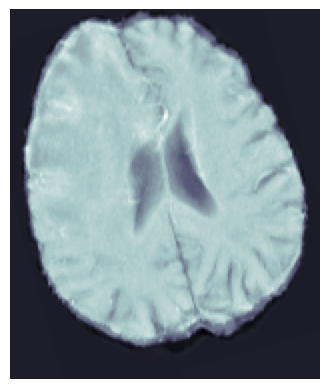

In [218]:
patient_images = prepare_images("sub-02063373")

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal"),
    tf.keras.layers.RandomBrightness(factor = (-0.2, 0.5), value_range=(0, 1)),
    tf.keras.layers.RandomContrast(0.5),
    tf.keras.layers.RandomRotation(factor = (-0.07, 0.07), fill_mode = "nearest"),
    tf.keras.layers.RandomTranslation(
        height_factor = 0.025,
        width_factor = 0.05,
        fill_mode = "nearest"
    )
])

augmented_images = data_augmentation(patient_images)

plt.imshow(np.array(augmented_images[90,:,:,1]), cmap="bone")
plt.axis("off")

## Create AI architecture
To-do:
- custom loss (dice loss) or mutli-class loss https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75